## California wildfires 2017 - Thomas Fire analysis

The Thomas Fire was a massive wildfire that started in early December 2017 in Ventura and Santa Barbara counties and grew into California's largest fire ever.

![](../../static/img/thomasfire_cropped.jpg)

In [22]:
import arcgis
from arcgis import *
from arcgis.mapping import MapImageLayer

In [25]:
gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123') 

## Visualize the extent of damage

In [92]:
from ipywidgets import *

postfire = MapImageLayer('https://tiles.arcgis.com/tiles/DO4gTjwJVIJ7O9Ca/arcgis/rest/services/Digital_Globe_Imagery_Dec_11th/MapServer')

def side_by_side(address):
    location = geocode(address)[0]

    satmap1 = gis.map(location)
    satmap1.basemap = 'satellite'

    satmap2 = gis.map(location)
    satmap2.add_layer(postfire)

    satmap1.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap2.layout=Layout(flex='1 1', padding='6px', height='450px')

    box = HBox([satmap1, satmap2])
    return box

### Nob Hill, Ventura, CA

In [ ]:
side_by_side('Montclair Dr, Ventura, CA')

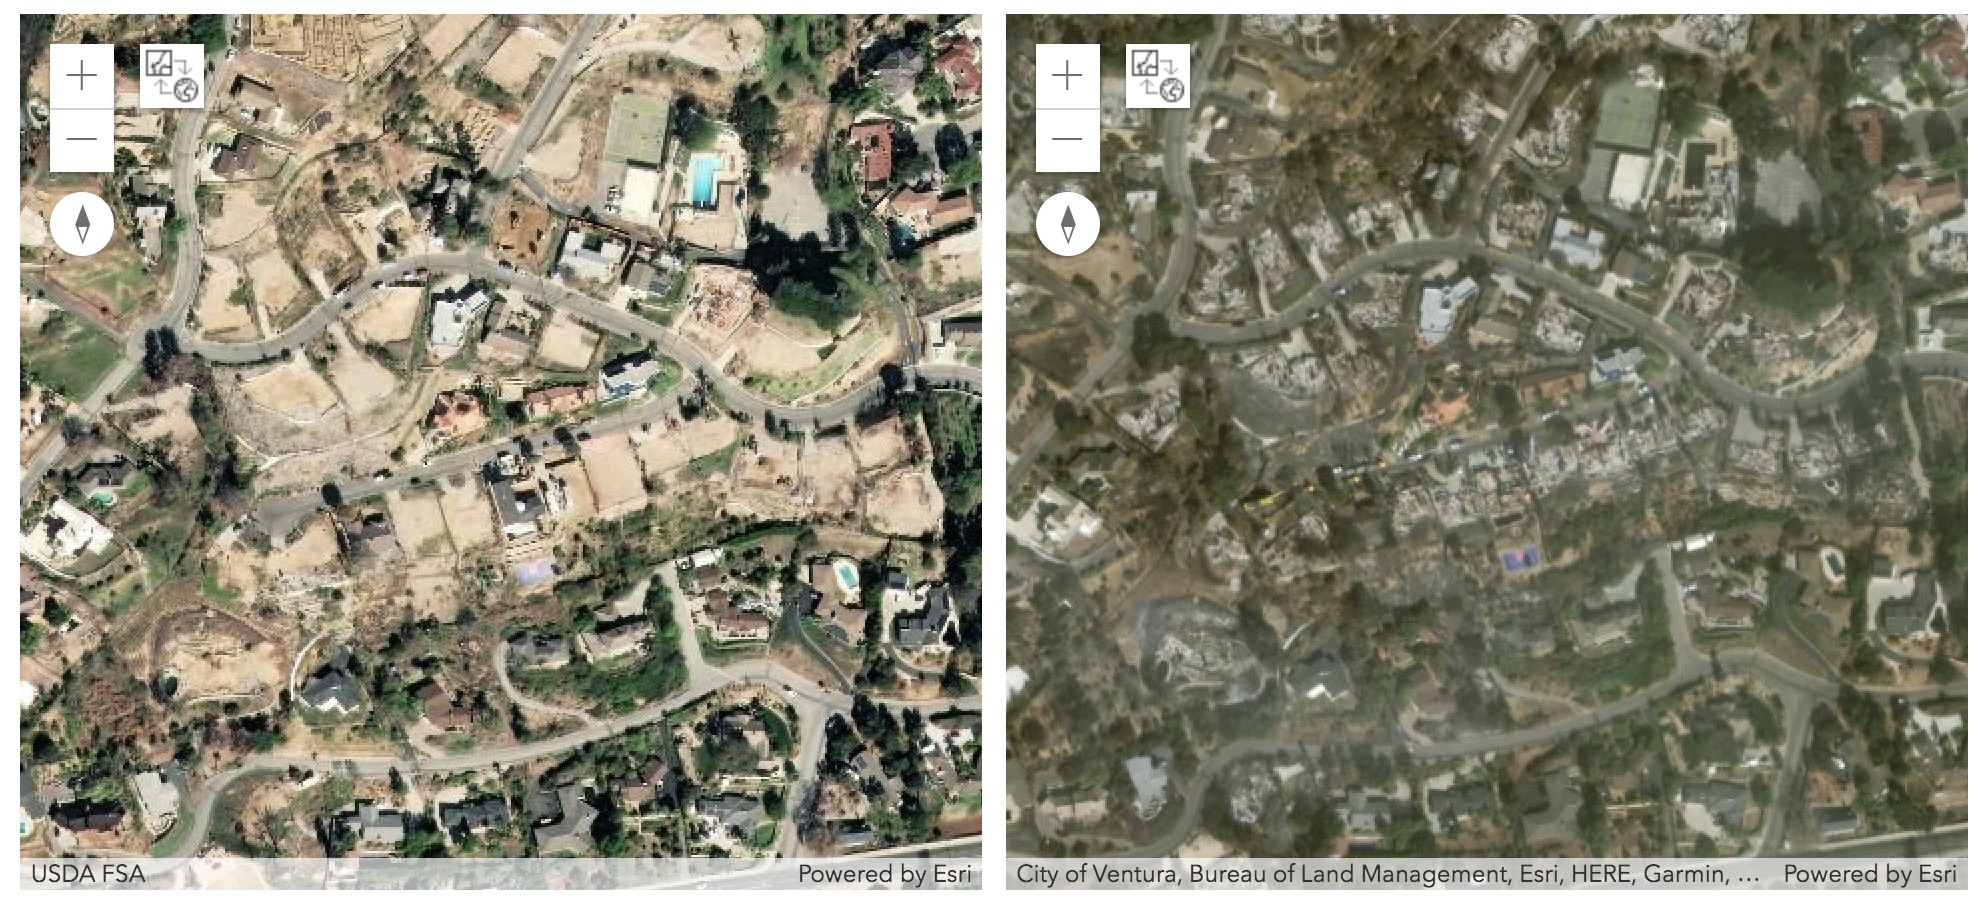

### Vista Del Mar Hospital, Ventura, CA

In [ ]:
side_by_side('801 Seneca St, Ventura, CA 93001')

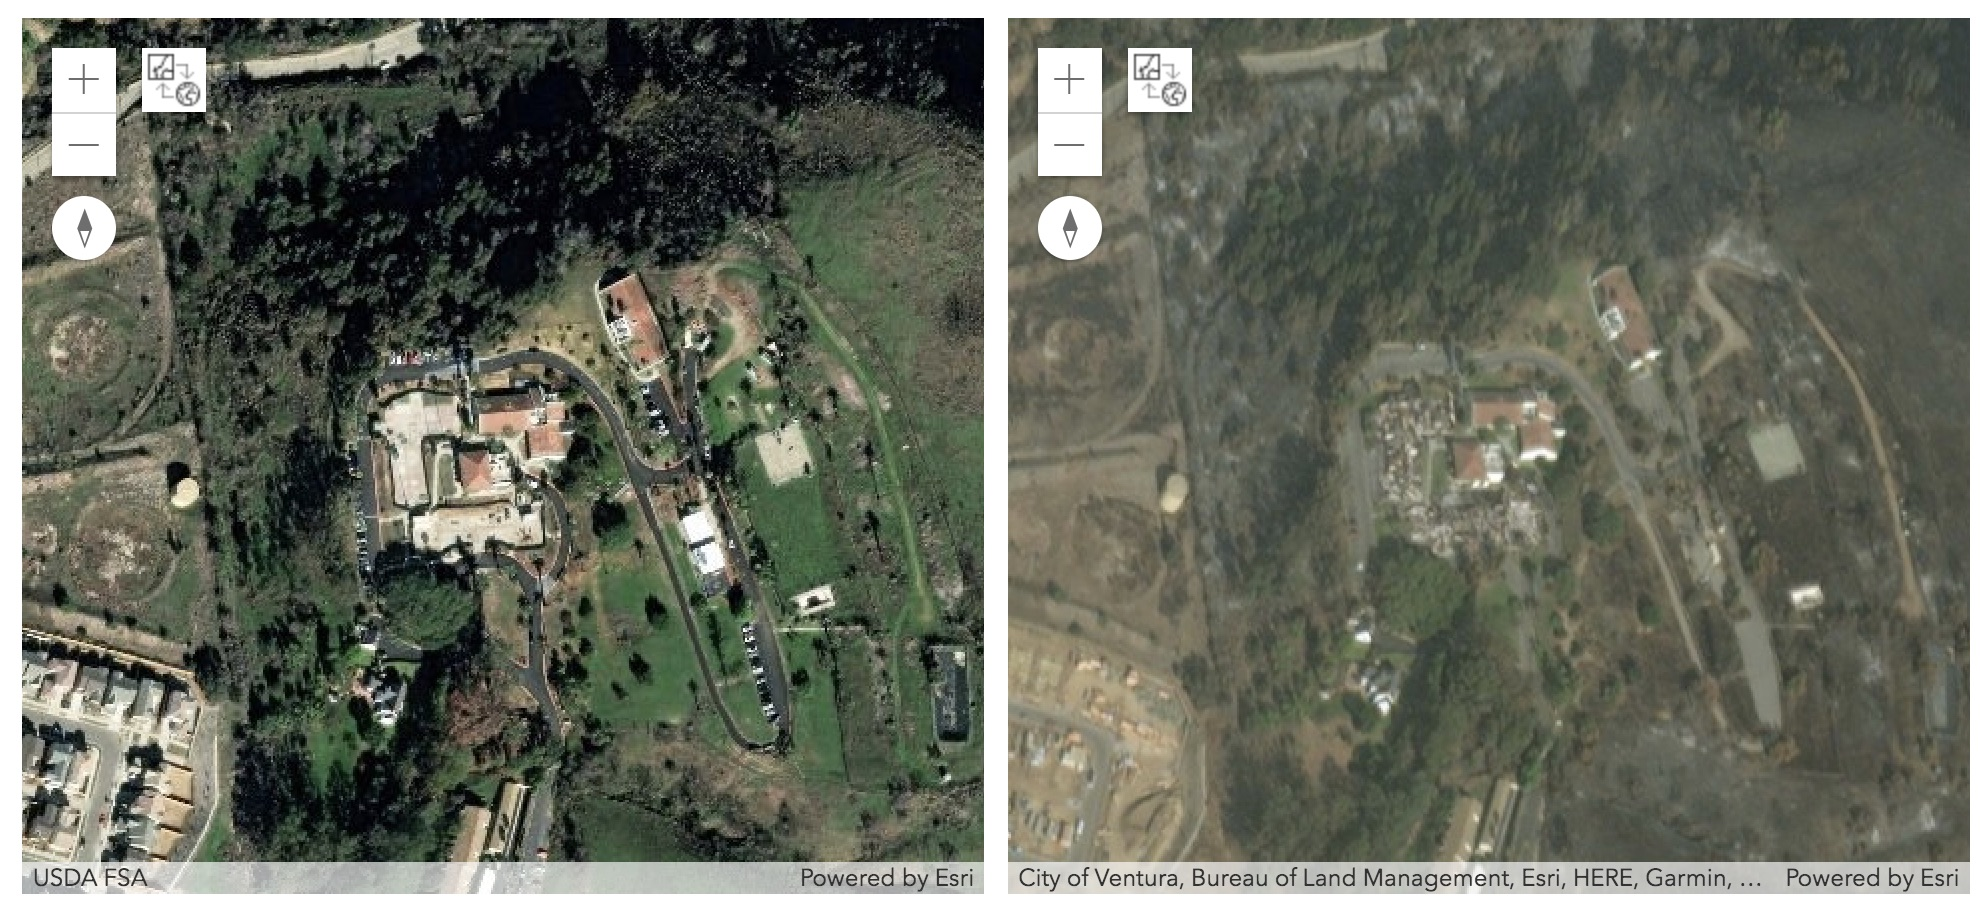

## Remote Sensing and Image Processing

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
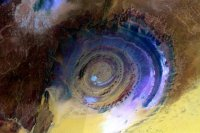

In [29]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

### Select before and after rasters

In [30]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'type': 'extent', 
       'xmax': -13305000, 'xmin': -13315000, 'ymax': 4106000, 'ymin': 4052000}

arcgis.env.analysis_extent = {"xmin":-13337766,"ymin":4061097,"xmax":-13224868,"ymax":4111469,
                              "spatialReference":{"wkid":102100,"latestWkid":3857}}

landsat.extent = aoi

In [31]:
import pandas as pd
from datetime import datetime

selected = landsat.filter_by(where="(Category = 1)",
                             time=[datetime(2017, 11, 15), datetime(2018, 1, 1)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(5)

,AcquisitionDate,CloudCover,DayOfYear,GroupName,OBJECTID,SHAPE,Shape_Area,Shape_Length
0,2017-11-23 18:34:42.440000057,0.0441,327,LC80420362017327LGN00_MTL,668630,"{""rings"": [[[-13208036.3849, 4199102.123899996...",5.131484e+10,906509.716682
1,2017-12-09 18:34:39.503999949,0.2136,343,LC80420362017343LGN00_MTL,681950,"{""rings"": [[[-13208251.4004, 4199098.6241], [-...",5.127378e+10,906136.246386
2,2017-12-25 18:34:42.003000021,0.6529,359,LC80420362017359LGN00_MTL,692453,"{""rings"": [[[-13210387.2213, 4199063.157099999...",5.129089e+10,906293.823931


In [32]:
prefire = landsat.filter_by('OBJECTID=2202594') # 2017-11-23 
midfire = landsat.filter_by('OBJECTID=2210579') # 2017-12-09 

## Visual Assessment

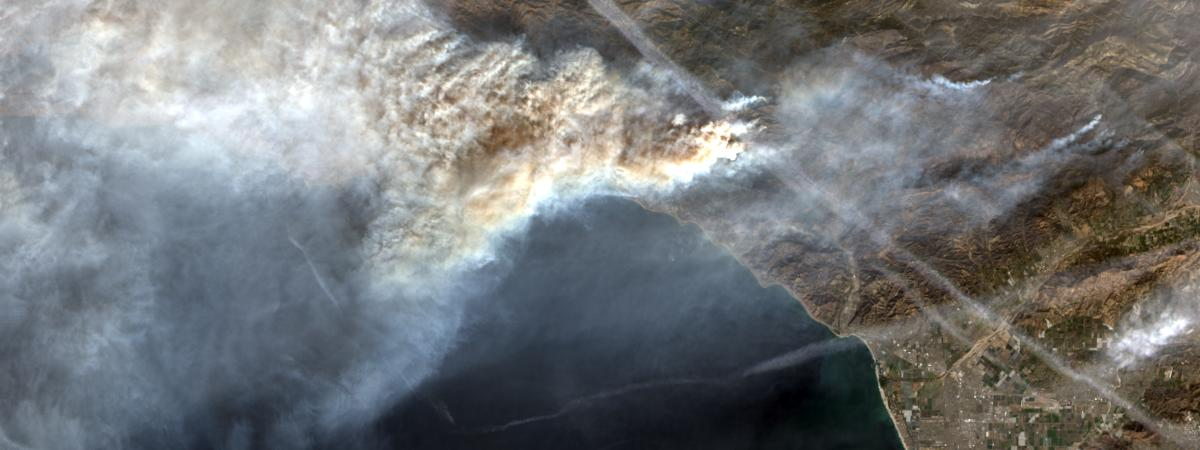

In [33]:
from arcgis.raster.functions import *

apply(midfire, 'Natural Color with DRA')

### Visualize Burn Scars

Extract the [6, 4, 1] bands to improve visibility of fire and burn scars. This band combination pushes further into the SWIR range of the electromagnetic spectrum, where there is less susceptibility to smoke and haze generated by a burning fire.

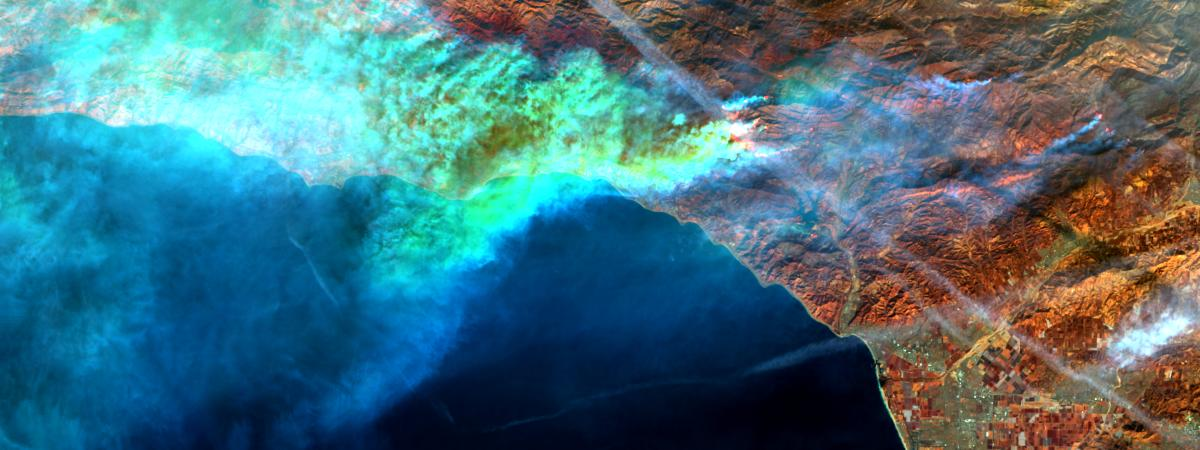

In [34]:
extract_band(midfire, [6,4,1])

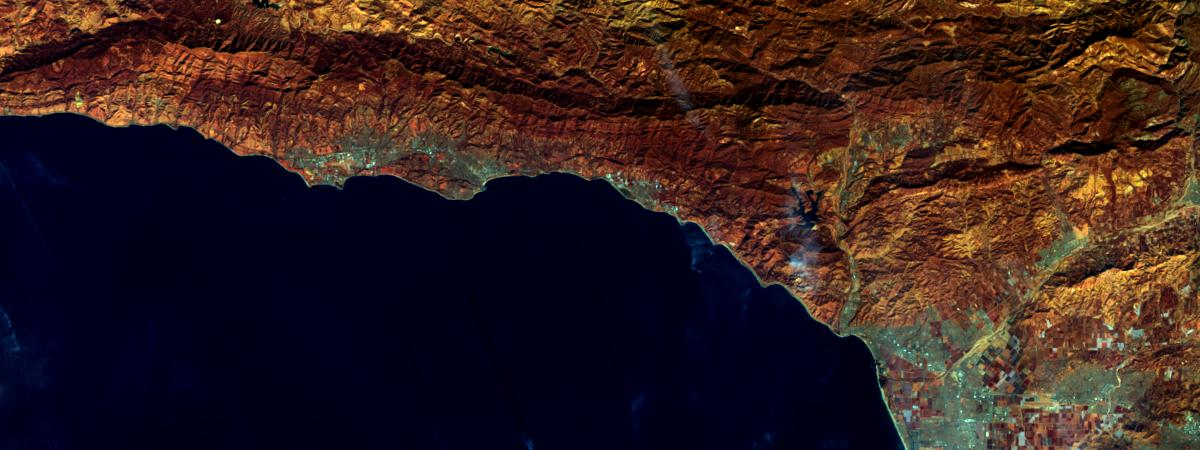

In [35]:
extract_band(prefire, [6,4,1])

For comparison, the same area before the fire started shows no burn scar.

## Quantitative Assessment

The **Normalized Burn Ratio (NBR)** can be used to delineate the burnt areas and identify the severity of the fire. 

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 5 and the short-wave infrared band 7:
\begin{align}
{\mathbf{NBR}} = \frac{\mathbf{B_5} - \mathbf{B_7}}{\mathbf{B_5} + \mathbf{B_7}} \\   
\end{align}

The NBR equation was designed to be calcualted from reflectance, but it can be calculated from radiance and digital_number_(dn) with changes to the burn severity table below. 

For a given area, NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is judged by taking the difference between these two index layers:

\begin{align}
{\Delta \mathbf{NBR}} = \mathbf{NBR_{prefire}} - \mathbf{NBR_{postfire}} \\   
\end{align}

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:


| \begin{align}{\Delta \mathbf{NBR}}  \end{align}      | Burn Severity |
| ------------- |:-------------:|
| 0.1 to 0.27   | Low severity burn |
| 0.27 to 0.44  | Medium severity burn |
| 0.44 to 0.66 | Moderate severity burn |
| > 0.66 | High severity burn |

[Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio]

### Use Band Arithmetic and Map Algebra 

In [36]:
nbr_prefire  = band_arithmetic(prefire, "(b5 - b7) / (b5 + b7+1000)")
nbr_postfire = band_arithmetic(midfire, "(b5 - b7) / (b5 + b7+1000)")

nbr_diff = nbr_prefire - nbr_postfire

In [37]:
burnt_areas = colormap(remap(nbr_diff,
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'), 
                             colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0,    0]])

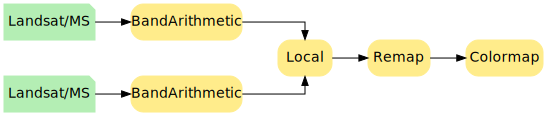

In [38]:
burnt_areas.draw_graph()

### Area calculation

In [39]:
ext = {"xmax": -13246079.10806628, "ymin": 4035733.9433013694, "xmin": -13438700.419344831, "ymax": 4158033.188557592,
       "spatialReference": {"wkid": 102100, "latestWkid": 3857}, "type": "extent"}
pixx = (ext['xmax'] - ext['xmin']) / 1200.0
pixy = (ext['ymax'] - ext['ymin']) / 450.0

res = burnt_areas.compute_histograms(ext, pixel_size={'x':pixx, 'y':pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

### Report burnt area

In [40]:
from IPython.display import HTML
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

HTML('<h3>Thomas fire has consumed <i>{:,} acres</i>  till {}</h3>.'.format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

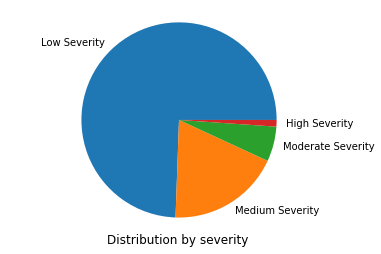

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Distribution by severity', y=-0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 'Moderate Severity', 'High Severity']);
plt.axis('equal');

### Visualize burnt areas


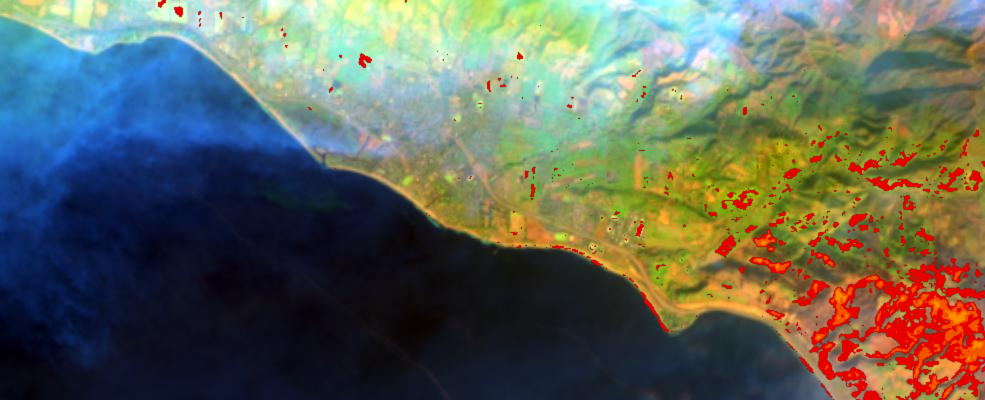

In [88]:
m = gis.map('Carpinteria, CA')
m

In [43]:
m.add_layer([midfire, burnt_areas])

## Raster to Feature layer conversion

Use Raster Analytics and Geoanalytics to convert the burnt area raster to a feature layer. The `to_features()` method converts the raster to a feature layer and `create_buffers()` fills holes in the features and dissolves them to output one feature that covers the extent of the Thomas Fire.

In [47]:
persisted_fire_output = burnt_areas.save()
persisted_fire_output_layer = persisted_fire_output.layers[0]
fire_item = persisted_fire_output_layer.to_features(output_name='ThomasFire_Boundary')

fire_layer = fire_item.layers[0]
fire_layer.filter = 'st_area_sh > 3000000'

In [75]:
fire = gis.content.search('ThomasFire_Boundary', 'Feature Layer')[0]
fire

<Item title:"ThomasFire_Boundary" type:Feature Layer Collection owner:admin>

## Impact Assessment

### Compute infrastructure and human impact

In [77]:
from arcgis.geoenrichment import enrich
from arcgis.features import SpatialDataFrame, FeatureLayer

sdf = SpatialDataFrame.from_layer(fire.layers[0])

fire_geometry = sdf.iloc[0].SHAPE
sa_filter = geometry.filters.intersects(geometry=fire_geometry, sr=4326)

secondary_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/1")
secondary_roads = secondary_roads_layer.query(geometry_filter=sa_filter, out_sr=4326)

local_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/2")
local_roads = local_roads_layer.query(geometry_filter=sa_filter, out_sr=4326)

def age_pyramid(df):
    import warnings
    import seaborn as sns
    import matplotlib.pyplot as plt

    %matplotlib inline
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.options.mode.chained_assignment = None 
    plt.style.use('ggplot')

    df = df[[x for x in impacted_people.columns if 'MALE' in x or 'FEM' in x]]
    sf = pd.DataFrame(df.sum())
    sf['age'] = sf.index.str.extract('(\d+)').astype('int64')

    f = sf[sf.index.str.startswith('FEM')]
    m = sf[sf.index.str.startswith('MALE')]
    f = f.sort_values(by='age', ascending=False).set_index('age')
    m = m.sort_values(by='age', ascending=False).set_index('age')

    popdf = pd.concat([f, m], axis=1)
    popdf.columns = ['F', 'M']
    popdf['agelabel'] = popdf.index.map(str) + ' - ' + (popdf.index+4).map(str)
    popdf.M = -popdf.M
    
    sns.barplot(x="F", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
    sns.barplot(x="M",  y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
    plt.ylabel('Age group')
    plt.xlabel('Number of people');
    return plt;

### Visualize affected roads on map


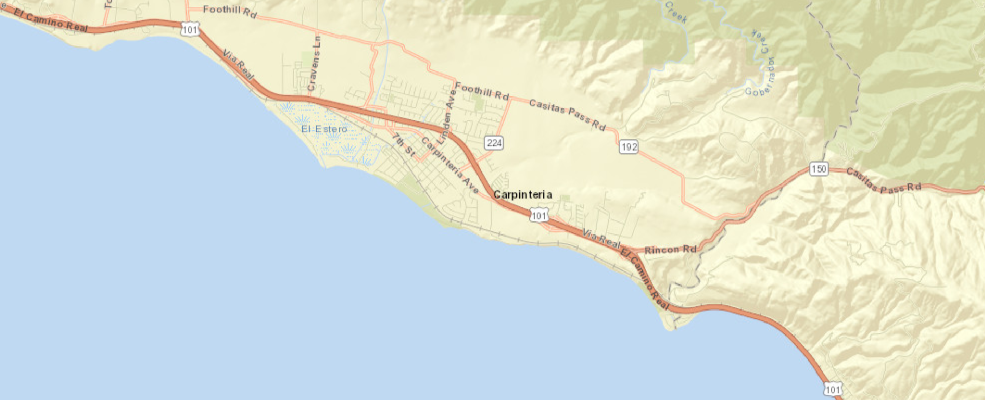

In [89]:
impactmap = gis.map('Carpinteria, CA')
impactmap.basemap = 'streets'

impactmap

In [79]:
impactmap.draw([local_roads, secondary_roads])

### Age Pyramid of affected population

In [ ]:
impacted_people = enrich(sdf, 'Age')
age_pyramid(impacted_people);

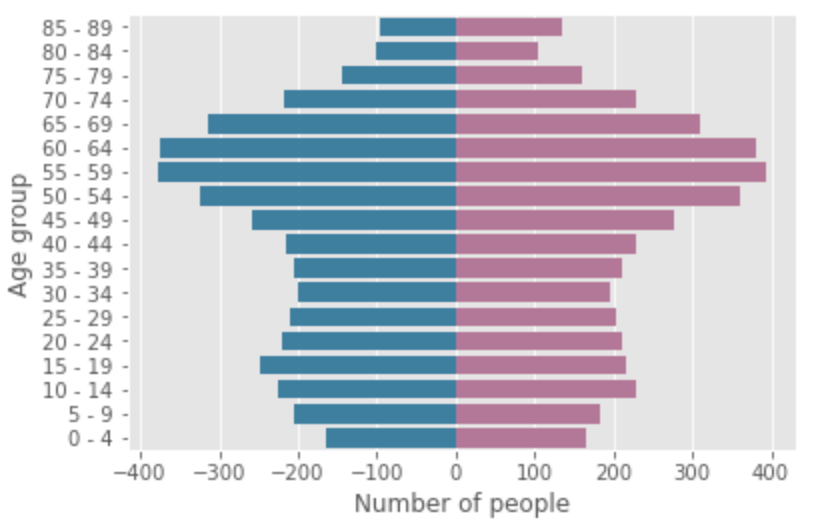